# Прогнозирование температуры звезды
## Постановка задачи

Заказчик исследования - обсерватория. «Небо на ладони». Цель работы - разработать метод, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. 

Обычно для расчёта температуры учёные пользуются следующими методами:
* Закон смещения Вина
* Закон Стефана-Больцмана
* Спектральный анализ

Каждый из них имеет свои плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет более точным и удобным, чем существующие.

В базе обсерватории есть характеристики уже изученных 240 звёзд.

Характеристики: 
* Относительная светимость L/Lo — светимость звезды относительно Солнца.
* Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
* Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
* Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
* Тип звезды:
** Коричневый карлик
** Красный карлик
** Белый карлик
** Звезды главной последовательности
** Сверхгигант
** Гипергигант
* Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.

На основании этих данных необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.

## Импорт библиотек
Импортируем необходимые для работы библиотеки.

In [1]:
from pathlib import Path
import re

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.float_format', '{:,.2f}'.format)

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import math
from math import ceil

import numpy as np
import random

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

import torch 
import torch.nn as nn

from skorch.callbacks import EpochScoring, EarlyStopping
from skorch import NeuralNetRegressor
from skorch.dataset import ValidSplit

# попробую вставит сюда:
random.seed(69)
np.random.seed(69)
torch.manual_seed(69)
torch.use_deterministic_algorithms(True)

## Импорт и первичное исследование данных
### Импорт данных
Импортируем исходный датасет.

In [2]:
my_path = Path('/home/klarazetkin/Documents/yandex/module_4/project_4')
file_name = str(my_path) + '/' + '6_class.csv'
if my_path.is_dir():
    df = pd.read_csv(file_name)
else:
    df = pd.read_csv('/datasets/6_class.csv')
    
# сохраним резервную копию исходного датасета
df_original = df 

### Первичное исследование
Датасет состоит из 7 колонок и 240 строк, которые соответствуют объектам - уже изученным звездам. Датасет сравнительно маленький.

**Обучающие признаки:**
* Luminosity(L/Lo) - светимость звезды относительно Солнца
* Radius(R/Ro) - радиус звезды относительно радиуса Солнца
* Absolute magnitude(Mv) - абсолютная звездная величина
* Star type - тип звезды
* Star color - звездный цвет

**Целевой признак**, который должна будет предсказать модель, - 
* Temperature (K) — температура в кельвинах

В колонке Unnamed содержится id звезды, его стоит удалить.

Типы данных в основном адекватны. Стоит заменить тип данных в колонке Star type на категориальный: фактически в колонке содержатся цифровые обозначения категорий звезд, стоит перевести их в тип object и дальше работать с ними как с категориальными данными.

На этапе первичного исследования данных явных выборосов не обнаружено.

Дубликатов и пустых значений в датасете нет. 

In [3]:
df.head()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.00,0.17,16.12,0,Red
1,1,3042,0.00,0.15,16.60,0,Red
2,2,2600,0.00,0.10,18.70,0,Red
3,3,2800,0.00,0.16,16.65,0,Red
4,4,1939,0.00,0.10,20.06,0,Red


In [4]:
df.shape

(240, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


In [6]:
df.describe()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.00,240.00,240.00,240.00,240.00,240.00
mean,119.50,"10,497.46","107,188.36",237.16,4.38,2.50
std,69.43,"9,552.43","179,432.24",517.16,10.53,1.71
min,0.00,"1,939.00",0.00,0.01,-11.92,0.00
25%,59.75,"3,344.25",0.00,0.10,-6.23,1.00
50%,119.50,"5,776.00",0.07,0.76,8.31,2.50
75%,179.25,"15,055.50","198,050.00",42.75,13.70,4.00
max,239.00,"40,000.00","849,420.00","1,948.50",20.06,5.00


In [7]:
df.duplicated().sum()

0

In [8]:
df.isna().mean()

Unnamed: 0               0.00
Temperature (K)          0.00
Luminosity(L/Lo)         0.00
Radius(R/Ro)             0.00
Absolute magnitude(Mv)   0.00
Star type                0.00
Star color               0.00
dtype: float64

## Проверка корреляций в исходном датасете
### Тепловая карта и матрица корреляций
Построим тепловую карту и матрицу корреляций. 

Из построенных графиков видно наличие корреляций между целевым признаком (температурой) и другими признаками:
* средней силы положительная корреляция с относительной светимостью (Luminosity) - К = 0.39;
* средней силы отрицательная корреляция с абсолютной звездной величиной (Absolute magnitude) - К = -0.41

Матрица корреляций показывает средней силы положительную корреляцию с типом звезды, однако это категориальный столбец, и, хотя зависимость, вероятно, есть, не стоит ее оценивать на этом этапе.

Кроме того, есть корреляция целевого признака с id (колонка Unnamed), но это ложная корреляция. Столбец неинформативный и будет удален.

In [9]:
# функция печати тепловой карты коэффициентов корреляции
def correlation_heatmap(dataframe):
    plt.figure(figsize=(18, 7))

    sns.heatmap(dataframe, annot=True, fmt=".5f", linewidths=.1, cmap='RdYlGn')
    plt.title('Матрица коэффициентов корреляции', fontsize=15)
    plt.ylabel('Признак', fontsize=15)
    plt.xlabel('Признак', fontsize=15)

In [10]:
df.columns

Index(['Unnamed: 0', 'Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)', 'Star type', 'Star color'],
      dtype='object')

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv)
Temperature (K),1.00,0.39,0.06,-0.42
Luminosity(L/Lo),0.39,1.00,0.53,-0.69
Radius(R/Ro),0.06,0.53,1.00,-0.61
Absolute magnitude(Mv),-0.42,-0.69,-0.61,1.00


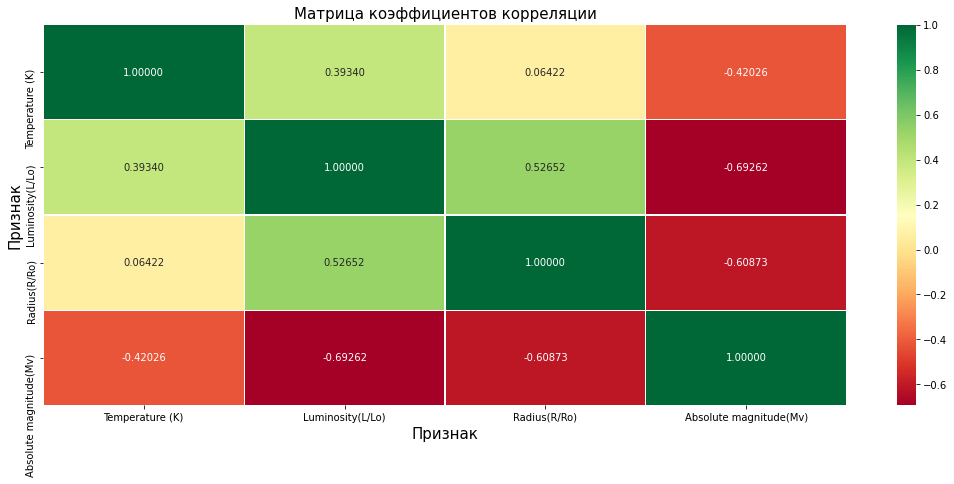

In [11]:
numerical_columns = ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']

display(df[numerical_columns].corr())
correlation_heatmap(df[numerical_columns].corr())

In [12]:
# функция печати матрицы диаграмм рассеяния
def scatter_matrix(dataframe):
    pd.plotting.scatter_matrix(
        dataframe, 
        figsize=(12, 12)
    )

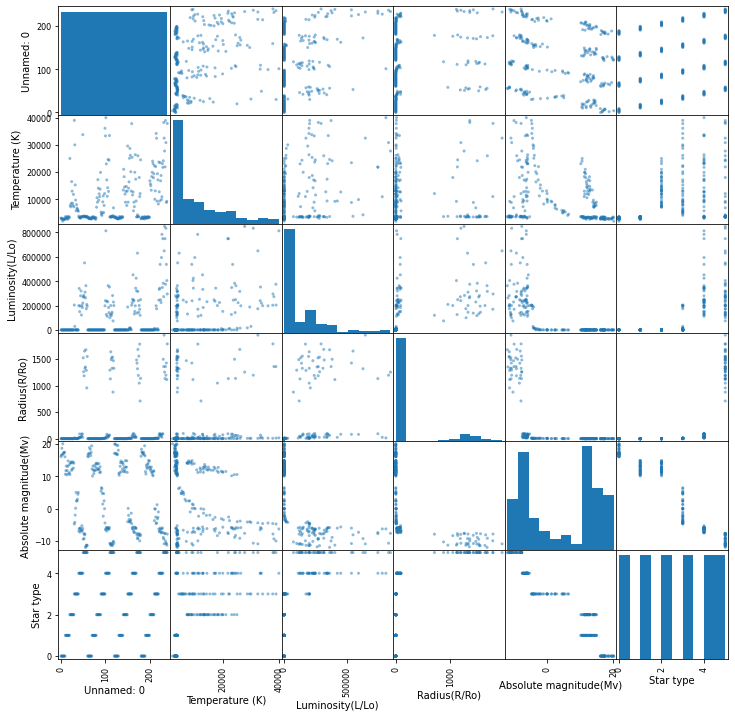

In [13]:
scatter_matrix(df)

## Предобработка данных
### Переименование столбцов
Для удобства работы переведем названия стобцов в snake_case.

In [14]:
def convert_to_snake_case(camel_input):
    words = re.findall(r'[A-Z]?[a-z]+|[A-Z]{2,}(?=[A-Z][a-z]|\d|\W|$)|\d+', camel_input)
    return '_'.join(map(str.lower, words))


# Let's test it
test_strings = [
    'CamelCase',
    'camelCamelCase',
    'Camel2Camel2Case',
    'getHTTPResponseCode',
    'get200HTTPResponseCode',
    'getHTTP200ResponseCode',
    'HTTPResponseCode',
    'ResponseHTTP',
    'ResponseHTTP2',
    'Fun?!awesome',
    'Fun?!Awesome',
    '10CoolDudes',
    '20coolDudes',
    'Camel Case (20/0)'
]
for test_string in test_strings:
    print(convert_to_snake_case(test_string))

camel_case
camel_camel_case
camel_2_camel_2_case
get_http_response_code
get_200_http_response_code
get_http_200_response_code
http_response_code
response_http
response_http_2
fun_awesome
fun_awesome
10_cool_dudes
20_cool_dudes
camel_case_20_0


In [15]:
columns_dict = dict()
for column in df.columns:
    columns_dict[column] = convert_to_snake_case(column)
    
df = df.rename(columns=columns_dict)
df.columns

Index(['unnamed_0', 'temperature', 'luminosity_lo', 'radius_ro',
       'absolute_magnitude_mv', 'star_type', 'star_color'],
      dtype='object')

In [16]:
# еще укоротим названия, где это нужно
df = df.rename(columns={'luminosity_lo': 'luminosity', 'radius_ro': 'radius', 'absolute_magnitude_mv': 'absolute_magnitude'})

### Удаление неинформативных признаков
Удалим столбец 'unnamed_0', в котором содержится id звезды.

In [17]:
df = df.drop('unnamed_0', axis=1)

### Замена типов данных
Значения в колонке 'star_type' сейчас имеют тип int, но по факту там содержатся категориальные значения. Сначала заменим цифры на соответствующие типы звезд (произведем обратную замену), а впоследствии кодируем этот столбец методом OHE. 

После замены данных тип столбца изменился на object, что и требовалось.

In [18]:
star_types_dict = {0: 'Коричневый карлик', 
                   1: 'Красный карлик', 
                   2: 'Белый карлик', 
                   3: 'Звёзды главной последовательности', 
                   4: 'Сверхгигант', 
                   5: 'Гипергигант'}

df['star_type'] = df['star_type'].map(star_types_dict)


In [19]:
df['star_type'].describe()

count                240
unique                 6
top       Красный карлик
freq                  40
Name: star_type, dtype: object

In [20]:
df['star_type'].unique()

array(['Коричневый карлик', 'Красный карлик', 'Белый карлик',
       'Звёзды главной последовательности', 'Сверхгигант', 'Гипергигант'],
      dtype=object)

### Устранение скрытых дубликатов
Проверим датасет на скрытые дубликаты. В столбце 'star_type' их нет. Зато они есть в столбце 'star_color'.

In [21]:
df['star_color'].value_counts()

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Yellowish White         3
Blue white              3
white                   3
Orange                  2
Whitish                 2
yellowish               2
Blue                    1
Pale yellow orange      1
Blue white              1
White-Yellow            1
Yellowish               1
Orange-Red              1
Blue-White              1
Name: star_color, dtype: int64

In [22]:
df['star_color'] = df['star_color'].str.strip().str.lower().str.replace('ish', '').str.replace(' ', '-')
df['star_color'].value_counts()

red                   112
blue                   56
blue-white             41
yellow-white           11
white                  10
yellow                  3
orange                  2
whit                    2
orange-red              1
white-yellow            1
pale-yellow-orange      1
Name: star_color, dtype: int64

In [23]:
color_dict = {'red': 'red', 
              'blue': 'blue', 
              'blue-white': 'blue-white',
              'yellow-white': 'yellow-white',
              'white': 'white',
              'yellow': 'yellow',
              'whit': 'white', 
              'orange': 'orange',
              'white-yellow': 'yellow-white', 
              'pale-yellow-orange': 'yellow', 
              'orange-red': 'red' }
df['star_color'] = df['star_color'].map(color_dict)
df['star_color'].value_counts()

red             113
blue             56
blue-white       41
white            12
yellow-white     12
yellow            4
orange            2
Name: star_color, dtype: int64

### Обработка выбросов
Проверим датасет на выбросы. Есть одна крайне подозрительная колонка - 'luminosity'. Если судить по описанию датасета, в ней более 25% нулевых значений. Однако при более внимательной проверке видим, что в данной колонке вообще нет нулевых значений, но есть очень малые. Возможно, для звезд это нормально. Оставим эти значения без изменений.

In [24]:
df.describe()

,temperature,luminosity,radius,absolute_magnitude
count,240.00,240.00,240.00,240.00
mean,"10,497.46","107,188.36",237.16,4.38
std,"9,552.43","179,432.24",517.16,10.53
min,"1,939.00",0.00,0.01,-11.92
25%,"3,344.25",0.00,0.10,-6.23
50%,"5,776.00",0.07,0.76,8.31
75%,"15,055.50","198,050.00",42.75,13.70
max,"40,000.00","849,420.00","1,948.50",20.06


In [25]:
df.query('luminosity > 0.00 & luminosity < 0.07').luminosity.unique().min()

8e-05

In [26]:
df.query('luminosity == 0.0000').luminosity.count()

0

In [27]:
df.query('luminosity < 0.0001').luminosity.count()

2

### Вывод по этапу предобработки данных : оценка предобработанного датасета
По итогу предобработки получился датасет из шести колонок и 240 строк. Целевой признак - 'temperature' - температура на поверхности звезды в K. Из пяти обучающих признаков три численные ('luminosity', 'radius', 'absolute_magnitude') и два категориальные ('star_type', 'star_color'). Выбросов и пустых значений нет.

Прослеживаются средней силы корреляции между целевым признаком и двумя численными признаками: абсолютной звездной величиной (K = -0.42) и относительной светимостью (K = 0.39). В результате предобработки корреляции не изменились.


In [28]:
df.shape

(240, 6)

In [29]:
df.describe()

,temperature,luminosity,radius,absolute_magnitude
count,240.00,240.00,240.00,240.00
mean,"10,497.46","107,188.36",237.16,4.38
std,"9,552.43","179,432.24",517.16,10.53
min,"1,939.00",0.00,0.01,-11.92
25%,"3,344.25",0.00,0.10,-6.23
50%,"5,776.00",0.07,0.76,8.31
75%,"15,055.50","198,050.00",42.75,13.70
max,"40,000.00","849,420.00","1,948.50",20.06


In [30]:
# функция печати гистограммы по одному столбцу
def print_hist(column, title='График распределения', bins=100):
    ax = df[column].hist(bins=bins)
    ax.set_title(title)
    ax.set_xlabel(column)
    ax.set_ylabel('Объекты датасета')

count      240.00
mean    10,497.46
std      9,552.43
min      1,939.00
25%      3,344.25
50%      5,776.00
75%     15,055.50
max     40,000.00
Name: temperature, dtype: float64


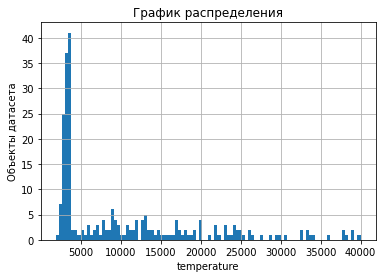

In [31]:
print(df.temperature.describe())
print_hist('temperature')

count       240.00
mean    107,188.36
std     179,432.24
min           0.00
25%           0.00
50%           0.07
75%     198,050.00
max     849,420.00
Name: luminosity, dtype: float64


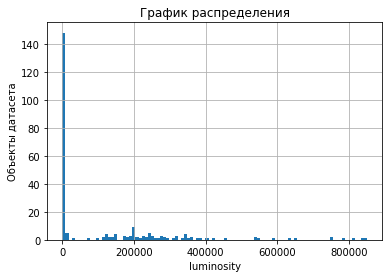

In [32]:
print(df.luminosity.describe())
print_hist('luminosity')

count     240.00
mean      237.16
std       517.16
min         0.01
25%         0.10
50%         0.76
75%        42.75
max     1,948.50
Name: radius, dtype: float64


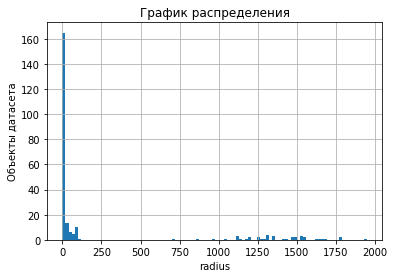

In [33]:
print(df.radius.describe())
print_hist('radius')

count   240.00
mean      4.38
std      10.53
min     -11.92
25%      -6.23
50%       8.31
75%      13.70
max      20.06
Name: absolute_magnitude, dtype: float64


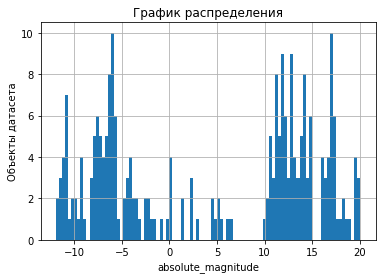

In [34]:
print(df.absolute_magnitude.describe())
print_hist('absolute_magnitude')

,temperature,luminosity,radius,absolute_magnitude
temperature,1.00,0.39,0.06,-0.42
luminosity,0.39,1.00,0.53,-0.69
radius,0.06,0.53,1.00,-0.61
absolute_magnitude,-0.42,-0.69,-0.61,1.00


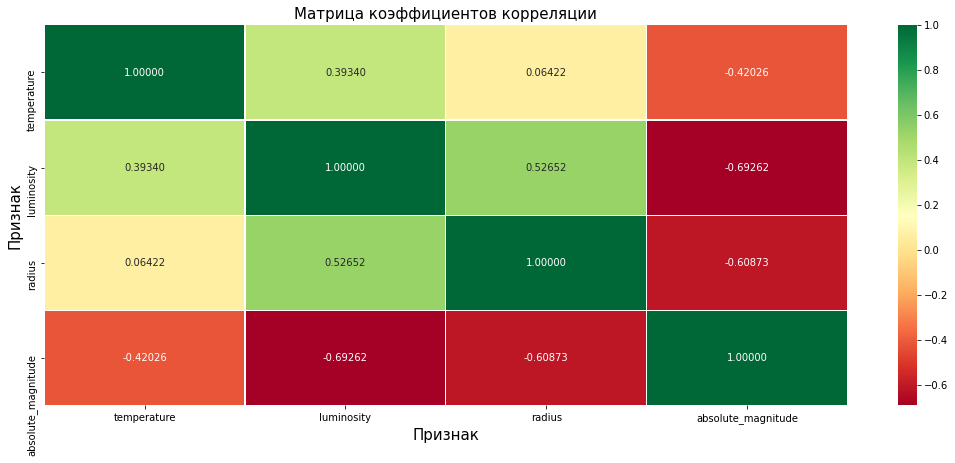

In [35]:
display(df.corr())
correlation_heatmap(df.corr())

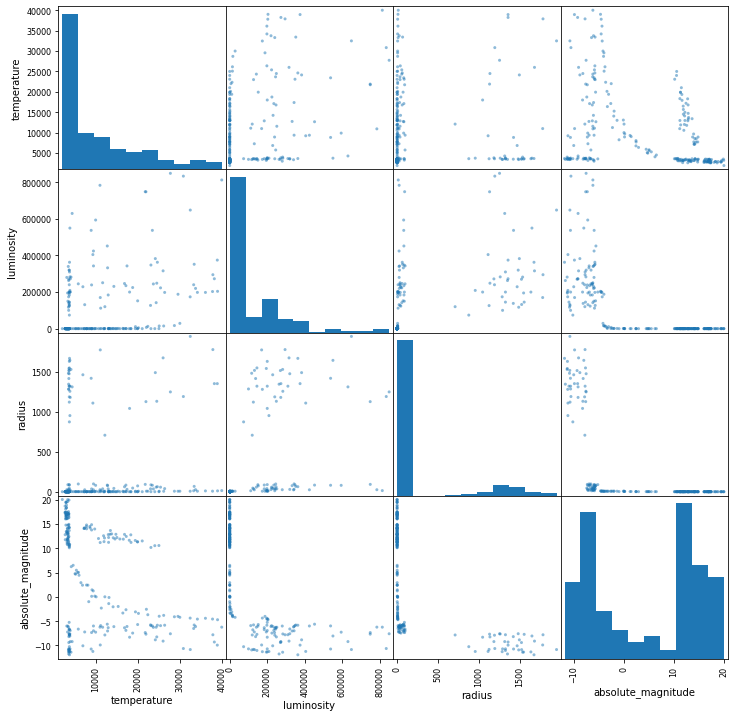

In [36]:
scatter_matrix(df)

## Подготовка тренировочного и обучающего датасетов
### Разделение датасетов на тренировочный и валидационный
Разделим датасеты на тренировочный и валидационный.

In [37]:
features = df.drop(['temperature'], axis=1)
target = df['temperature']

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, shuffle=True, random_state=666)

print('Количество объектов в X_train:', len(X_train))
print('Количество объектов в y_train:', len(y_train))

print('Количество объектов в X_test:', len(X_test))
print('Количество объектов в y_test:', len(y_test))

Количество объектов в X_train: 168
Количество объектов в y_train: 168
Количество объектов в X_test: 72
Количество объектов в y_test: 72


### Масштабирование численных признаков
Масштабируем численные признаки стандартным методом, используя StandardScaler().

In [38]:
target_column = 'temperature'
numerical_columns = ['luminosity', 'absolute_magnitude', 'radius']
categorical_columns = ['star_type', 'star_color']

In [39]:
scaler = StandardScaler()
scaler.fit(X_train[numerical_columns])

for dataset in [X_train, X_test]:
    dataset[numerical_columns] = scaler.transform(dataset[numerical_columns])

display(X_train.head())
display(X_test.head())

,luminosity,radius,absolute_magnitude,star_type,star_color
235,1.44,2.47,-1.42,Гипергигант,blue
19,-0.57,-0.42,0.64,Красный карлик,red
237,2.31,2.61,-1.49,Гипергигант,white
109,1.31,-0.28,-1.01,Сверхгигант,blue
233,3.98,2.25,-1.19,Гипергигант,blue-white


,luminosity,radius,absolute_magnitude,star_type,star_color
65,-0.57,-0.43,1.22,Коричневый карлик,red
165,0.13,-0.37,-1.15,Сверхгигант,blue
224,0.75,-0.29,-1.07,Сверхгигант,blue
188,-0.57,-0.43,1.45,Коричневый карлик,red
136,-0.57,-0.42,0.67,Красный карлик,red


### Кодирование категориальных признаков
Кодируем категориальные признаки методом OHE. Поскольку уникальных значений в категориальных колонках мало, укрупнять признаки не нужно. Проверили, что колонки в получившихся датасетах совпали.

In [40]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False, dtype='int32')
ohe.fit(X_train[categorical_columns])

def get_ohe(dataset):
    temp_dataset = pd.DataFrame(
        data=ohe.transform(dataset[categorical_columns]), 
        columns=ohe.get_feature_names_out())
 
    dataset.drop(columns=categorical_columns, axis=1, inplace=True)
    
    dataset = pd.concat([dataset.reset_index(drop=True), temp_dataset], axis=1)
    return dataset

In [41]:
X_train = get_ohe(X_train)
X_test = get_ohe(X_test)

In [42]:
display(X_train.head())
display(X_test.head())

,luminosity,radius,absolute_magnitude,star_type_Гипергигант,star_type_Звёзды главной последовательности,star_type_Коричневый карлик,star_type_Красный карлик,star_type_Сверхгигант,star_color_blue-white,star_color_red,star_color_white,star_color_yellow,star_color_yellow-white
0,1.44,2.47,-1.42,1,0,0,0,0,0,0,0,0,0
1,-0.57,-0.42,0.64,0,0,0,1,0,0,1,0,0,0
2,2.31,2.61,-1.49,1,0,0,0,0,0,0,1,0,0
3,1.31,-0.28,-1.01,0,0,0,0,1,0,0,0,0,0
4,3.98,2.25,-1.19,1,0,0,0,0,1,0,0,0,0


,luminosity,radius,absolute_magnitude,star_type_Гипергигант,star_type_Звёзды главной последовательности,star_type_Коричневый карлик,star_type_Красный карлик,star_type_Сверхгигант,star_color_blue-white,star_color_red,star_color_white,star_color_yellow,star_color_yellow-white
0,-0.57,-0.43,1.22,0,0,1,0,0,0,1,0,0,0
1,0.13,-0.37,-1.15,0,0,0,0,1,0,0,0,0,0
2,0.75,-0.29,-1.07,0,0,0,0,1,0,0,0,0,0
3,-0.57,-0.43,1.45,0,0,1,0,0,0,1,0,0,0
4,-0.57,-0.42,0.67,0,0,0,1,0,0,1,0,0,0


In [43]:
print(X_train.columns == X_test.columns)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True]


### Вывод по подготовленным датасетам
Подготовлены тренировочный, валидационный и тестовый датасеты. После кодирования категориальных признаков в каждом из них 13 колонок. Колонки совпадают. Категориальные признаки кодированы методом OHE, численные признаки масштабированы с использование StandardScaler(). Пустых значений нет, выбросов нет. Датасеты пригодны к обучению на них моделей.

In [44]:
print(X_train.shape)
X_train.info()

(168, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 13 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   luminosity                                   168 non-null    float64
 1   radius                                       168 non-null    float64
 2   absolute_magnitude                           168 non-null    float64
 3   star_type_Гипергигант                        168 non-null    int32  
 4   star_type_Звёзды главной последовательности  168 non-null    int32  
 5   star_type_Коричневый карлик                  168 non-null    int32  
 6   star_type_Красный карлик                     168 non-null    int32  
 7   star_type_Сверхгигант                        168 non-null    int32  
 8   star_color_blue-white                        168 non-null    int32  
 9   star_color_red                               168 non-null    int32

In [45]:
print(X_test.shape)
X_test.info()

(72, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 13 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   luminosity                                   72 non-null     float64
 1   radius                                       72 non-null     float64
 2   absolute_magnitude                           72 non-null     float64
 3   star_type_Гипергигант                        72 non-null     int32  
 4   star_type_Звёзды главной последовательности  72 non-null     int32  
 5   star_type_Коричневый карлик                  72 non-null     int32  
 6   star_type_Красный карлик                     72 non-null     int32  
 7   star_type_Сверхгигант                        72 non-null     int32  
 8   star_color_blue-white                        72 non-null     int32  
 9   star_color_red                               72 non-null     int32  


Конвертируем датасеты пандас в тензоры:

In [46]:
X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

## Обучение моделей


### Построение базовой модели нейронной сети
Поскольку решается задача линейной регрессии, будем строить полносвязную прямую нейронную сеть. Поскольку датасет маленький, можно использовать сигмоидную функцию активации. В то же время согласно рекомендациям, данным в теории, лучше использовать ReLU.

Для многих задач подходит нейронная сеть с одним скрытым слоем ( https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw ).

Количество нейронов в скрытом слое, если это единственный скрытый слой, можно приблизительно рассчитать по формуле `sqrt(m*n)`, где m - количество нейронов в входном слое, а n - количество нейронов в выходном слое. 

Во входном слое 13 нейронов, соответствующие 13 колонкам датасета. В выходном слое один нейрон, соответствующий целевому признаку - температуре. Соответственно в скрытом слое будет пять нейронов.

Возьмем за отправную точку полносвязную прямую сеть с 13 входными нейронами, одним скрытым слоем на 4 нейрона, и выходным слоем, в котором один нейрон.

#### Функции для дальнейшей работы
Определим функции для инициализации сети, обучения сети и получения результатов.

In [47]:
# перепишу с предохранением :)
class MyNet2(nn.Module):
    def __init__(self,
                 n_neurons=[13, 32, 16, 15, 4, 2, 1], 
                 activation_functions=[nn.ReLU()], 
                 batchnorm=False, 
                 dropout=False, 
                 dropout_shares=np.zeros(10)):
        super(MyNet2, self).__init__()
        
        self.net_layers = []
        for i in range(1, len(n_neurons) - 1):
            # append Linear() layer
            self.net_layers.append(nn.Linear(n_neurons[i - 1], n_neurons[i]))
            
            # append Batchnorm() layer
            if batchnorm:
                self.net_layers.append(nn.BatchNorm1d(n_neurons[i]))
           
            # append activation function
            try:
                function = activation_functions[i-1]
            except:
                function = nn.ReLU()

            self.net_layers.append(function)
            
            # append Dropout() layer
            if dropout:
                try:
                    dropout_share = dropout_shares[i-1]
                except:
                    dropout_share = 0.0
                
                self.net_layers.append(nn.Dropout(p=dropout_share))
        
        # append out layer
        self.net_layers.append(nn.Linear(n_neurons[-2], n_neurons[-1]))
        
        self.net = nn.Sequential(*self.net_layers)

        self.init_weights()

    def forward(self, x):
        out = self.net.forward(x)
        return out

    def init_weights(layer):
        if isinstance(layer, nn.Linear):
            torch.nn.init.kaiming_normal_(layer.weight)
            layer.bias.data.fill_(0.01)    

In [48]:
# проверка, что работает
test_neurons = [13, 32, 16, 15, 4, 2, 1]
test_net_2 = MyNet2(n_neurons=test_neurons, 
                 activation_functions=[nn.ReLU(), nn.Tanh(), nn.Sigmoid()], 
                 batchnorm=False, 
                 dropout=True, 
                 dropout_shares=[0.11, 0.222, 0.666, 0.7, 0.911, 0.1919])
#test_net_2.forward(X_train)
print(test_net_2)
#educate(test_net_2, print_metrics_progress=False)
proceed_and_get_metrics(n_neurons=test_neurons, 
                        activation_functions=[nn.ReLU(), nn.Tanh(), nn.Sigmoid()], 
                        batchnorm=False, 
                        dropout=True, 
                        dropout_shares=[0.11, 0.222, 0.666, 0.7, 0.911, 0.1919])

MyNet2(
  (net): Sequential(
    (0): Linear(in_features=13, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.11, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.222, inplace=False)
    (6): Linear(in_features=16, out_features=15, bias=True)
    (7): Sigmoid()
    (8): Dropout(p=0.666, inplace=False)
    (9): Linear(in_features=15, out_features=4, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.7, inplace=False)
    (12): Linear(in_features=4, out_features=2, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.911, inplace=False)
    (15): Linear(in_features=2, out_features=1, bias=True)
  )
)


NameError: name 'proceed_and_get_metrics' is not defined

In [49]:
# обучение сети
def educate(net, batch_size=100, num_epochs=3_000, print_metrics_progress=True):
    num_batches = ceil(len(X_train)/batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    loss = nn.MSELoss()
    
    epochs_and_metrics = [] # Get metrics

    for epoch in range(num_epochs):
        
        order = np.random.permutation(len(X_train))
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size
            optimizer.zero_grad()
            
            # получение индексов текущего батча
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]

            preds = net.forward(X_batch).flatten() 

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()

        if epoch % 100 == 0:
            net.eval()
            
            preds_train = net.forward(X_train).flatten()
            rmse_train = torch.sqrt(loss(preds_train, y_train))

            preds_test = net.forward(X_test).flatten()
            rmse_test = torch.sqrt(loss(preds_test, y_test))
            
            if print_metrics_progress:
                print('RMSE on train:', rmse_train)
                print('RMSE on test:', rmse_test)
            
            epochs_and_metrics.append([epoch, rmse_train, rmse_test]) # Get metrics
      
    return make_epochs_and_metrics_df(epochs_and_metrics) # Get metrics


In [50]:
def make_epochs_and_metrics_df(epochs_and_metrics):
    epochs = [x[0] for x in epochs_and_metrics]
    rmse_train = [float(x[1]) for x in epochs_and_metrics]
    rmse_test = [float(x[2]) for x in epochs_and_metrics]
    
    epochs_and_metrics = pd.DataFrame({'Epoch': epochs, 
                                       'RMSE_train': rmse_train,
                                       'RMSE_test': rmse_test})
    return epochs_and_metrics

In [51]:
def make_graph(epochs_and_metrics):
    plt.figure(figsize=(9, 5))
    ax = epochs_and_metrics.loc[:, 'RMSE_train'].plot(x='epoch', style='o-', grid=True, legend=True)
    ax = epochs_and_metrics.loc[:, 'RMSE_test'].plot(x='epoch', style='o-', grid=True, legend=True)
    ax.set_xlabel('num_epoch / 100')
    plt.show()
    plt.clf()

In [52]:
# пайплайн
def proceed_and_get_metrics(n_neurons, activation_functions=[],
                            batchnorm=False, dropout=False, dropout_shares=np.zeros(10), 
                            batch_size=100, num_epochs=3_000, print_metrics_progress=False):

    # не уверена, что вставила рандом сид в правильное место
    random.seed(666)
    np.random.seed(666)
    torch.manual_seed(999)
    torch.use_deterministic_algorithms(True)
    
    net = MyNet2(n_neurons, activation_functions, batchnorm, dropout, dropout_shares)
    print(net)
    
    # preds_train = educate(net, batch_size, num_epochs) # возвращает предсказания по последнему батчу
    epochs_and_metrics = educate(net, batch_size, num_epochs, print_metrics_progress)
    make_graph(epochs_and_metrics)
    
    net.eval()
    loss = nn.MSELoss()
    
    preds_train = net.forward(X_train).flatten()
    loss_value_train = torch.sqrt(loss(preds_train, y_train))
    print('В результате:')
    print('RMSE на трейне:', loss_value_train)
    
    preds_test = net.forward(X_test).flatten()
    loss_value_test = torch.sqrt(loss(preds_test, y_test))
    print('RMSE на тесте:', loss_value_test)
    
    return net, preds_train, preds_test

#### Выбор функции активации
Используя конфигурацию с одним скрытым слоем, попробуем различные функции активации. Лучше всего себя показала функция nn.ReLU(): RMSE падает с увеличением количества эпох. Функции nn.Sigmoid() и nn.Tanh() сработали хуже. Поэтому функцией по умолчанию поставим nn.ReLU(). 

MyNet2(
  (net): Sequential(
    (0): Linear(in_features=13, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=1, bias=True)
  )
)


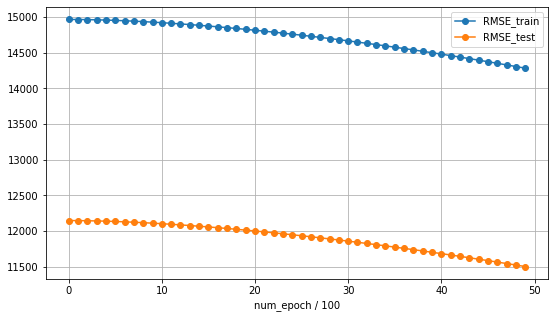

В результате:
RMSE на трейне: tensor(14260.7207, grad_fn=<SqrtBackward0>)
RMSE на тесте: tensor(11481.4141, grad_fn=<SqrtBackward0>)


MyNet2(
  (net): Sequential(
    (0): Linear(in_features=13, out_features=4, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=4, out_features=1, bias=True)
  )
)


<Figure size 432x288 with 0 Axes>

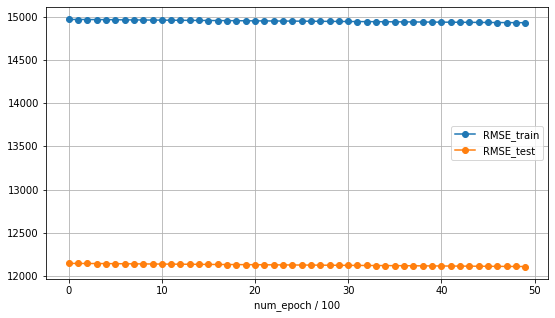

В результате:
RMSE на трейне: tensor(14928.4043, grad_fn=<SqrtBackward0>)
RMSE на тесте: tensor(12109.9209, grad_fn=<SqrtBackward0>)


MyNet2(
  (net): Sequential(
    (0): Linear(in_features=13, out_features=4, bias=True)
    (1): Tanh()
    (2): Linear(in_features=4, out_features=1, bias=True)
  )
)


<Figure size 432x288 with 0 Axes>

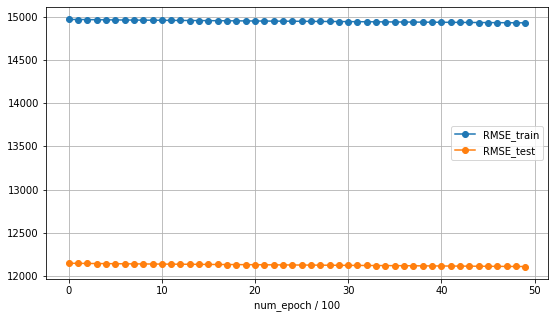

В результате:
RMSE на трейне: tensor(14927.0527, grad_fn=<SqrtBackward0>)
RMSE на тесте: tensor(12108.6260, grad_fn=<SqrtBackward0>)




<Figure size 432x288 with 0 Axes>

In [53]:
base_neurons = [13, 4, 1]
activation_functions = [[nn.ReLU()],
                        [nn.Sigmoid()],
                        [nn.Tanh()]]

for functions in activation_functions:
    proceed_and_get_metrics(n_neurons=base_neurons, 
                            num_epochs=5_000,
                            activation_functions=functions, 
                            print_metrics_progress=False)
    print(); print()

MyNet2(
  (net): Sequential(
    (0): Linear(in_features=13, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=1, bias=True)
  )
)


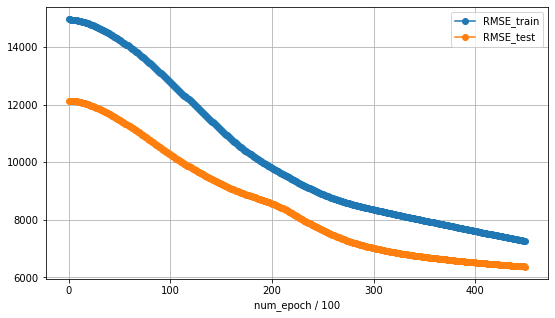

В результате:
RMSE на трейне: tensor(7258.6216, grad_fn=<SqrtBackward0>)
RMSE на тесте: tensor(6379.0977, grad_fn=<SqrtBackward0>)




<Figure size 432x288 with 0 Axes>

In [55]:
#КОД РЕВЬЮЕРА
base_neurons = [13, 4, 1]
activation_functions = [nn.ReLU()]

for functions in activation_functions:
    proceed_and_get_metrics(n_neurons=base_neurons, 
                            num_epochs=45_000,
                            activation_functions=functions, 
                            print_metrics_progress=False)
    print(); print()

MyNet2(
  (net): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


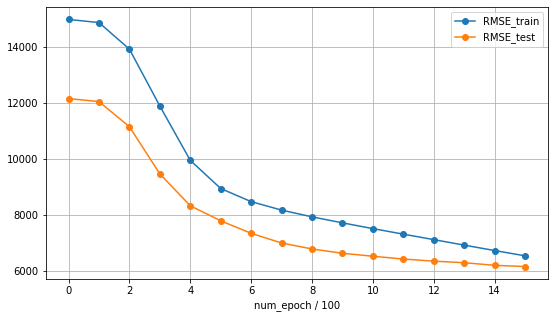

В результате:
RMSE на трейне: tensor(6362.0552, grad_fn=<SqrtBackward0>)
RMSE на тесте: tensor(6129.1792, grad_fn=<SqrtBackward0>)




<Figure size 432x288 with 0 Axes>

In [57]:
#КОД РЕВЬЮЕРА
base_neurons = [13, 64,32, 1]
activation_functions = [nn.ReLU()]

for functions in activation_functions:
    proceed_and_get_metrics(n_neurons=base_neurons, 
                            num_epochs=1600,
                            activation_functions=functions, 
                            print_metrics_progress=False)
    print(); print()

### Выбор базовой комбинации нейронов

#### Подбор лучшей комбинации нейронов с помощью RandomizedSearchCV
Попробуем подобрать лучшую комбинацию нейронов модели, используя RandomizedSearchCV, чтоб охватить большее количество вариантов. 

In [242]:
class MyNet(nn.Module):
    def __init__(self, 
                 activation=nn.ReLU(),
                 n_in_neurons=X_train.shape[1], # 13 neurons
                 n_hidden_neurons_1=11, 
                 n_hidden_neurons_2=9, 
                 n_hidden_neurons_3=7, 
                 n_hidden_neurons_4=5, 
                 #n_hidden_neurons_5=3,
                 n_out_neurons=1,    
                 dropout=0):
        
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = activation
        self.dp1 = nn.Dropout(p=dropout)
        
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = activation
        self.dp2 = nn.Dropout(p=dropout)
        
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.act3 = activation
        self.dp3 = nn.Dropout(p=dropout)
        
        self.fc4 = nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4)
        self.act4 = activation
        self.dp4 = nn.Dropout(p=dropout)
        
#         self.fc5 = nn.Linear(n_hidden_neurons_4, n_hidden_neurons_5)        
#         self.act5 = activation
#         self.dp5 = nn.Dropout(p=dropout)
        
        self.fc6 = nn.Linear(n_hidden_neurons_4, n_out_neurons) # FIX if uncomment previous layers 

        self.init_weights()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.dp1(x)
        
        x = self.fc2(x)
        x = self.act2(x)
        x = self.dp2(x)
        
        x = self.fc3(x)
        x = self.act3(x)
        x = self.dp3(x)
        
        x = self.fc4(x)
        x = self.act4(x)
        x = self.dp4(x)
        
#         x = self.fc5(x)
#         x = self.act5(x)
#         x = self.dp5(x)
        
        x = self.fc6(x)      
        
        return x
    
    def init_weights(layer):
        if isinstance(layer, nn.Linear):
            torch.nn.init.kaiming_normal_(layer.weight)
            layer.bias.data.fill_(0.01)

In [243]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

rmse_scorer = make_scorer(rmse)

skorch_regressor = NeuralNetRegressor(module=MyNet,
                                      device='cpu',  
                                      verbose=0,
                                      optimizer=torch.optim.Adam, 
                                      max_epochs=5000, 
                                      lr=1e-2,
                                      train_split=ValidSplit(cv=3),
                                      criterion=nn.MSELoss,
                                      callbacks=[
                ('val_rmse', EpochScoring(scoring=rmse_scorer, lower_is_better=True, name='RMSE')),
                ('estoper', EarlyStopping( lower_is_better=True, monitor='RMSE', patience=40)),
                ],
                                     )

skorch_regressor.fit(X_train, y_train.reshape(-1,1))

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=MyNet(
    (fc1): Linear(in_features=13, out_features=11, bias=True)
    (act1): ReLU()
    (dp1): Dropout(p=0, inplace=False)
    (fc2): Linear(in_features=11, out_features=9, bias=True)
    (act2): ReLU()
    (dp2): Dropout(p=0, inplace=False)
    (fc3): Linear(in_features=9, out_features=7, bias=True)
    (act3): ReLU()
    (dp3): Dropout(p=0, inplace=False)
    (fc4): Linear(in_features=7, out_features=5, bias=True)
    (act4): ReLU()
    (dp4): Dropout(p=0, inplace=False)
    (fc6): Linear(in_features=5, out_features=1, bias=True)
  ),
)

In [244]:
params = {  'module__n_hidden_neurons_1': range(40, 70, 2),
            'module__n_hidden_neurons_2': range(15, 40, 2),
            'module__n_hidden_neurons_3': range(5, 15, 2),
            'module__n_hidden_neurons_4': range(2, 5, 2),
            #'module__n_hidden_neurons_5': [3, 2]
         }

grid = RandomizedSearchCV(skorch_regressor, 
                          params, 
                          n_iter=1000,
                          cv=3, 
                          scoring='neg_root_mean_squared_error',
                          verbose=3, 
                          n_jobs=12) 

grid.fit(X_train, y_train.reshape(-1,1)) 

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits
[CV 1/3] END module__n_hidden_neurons_1=52, module__n_hidden_neurons_2=35, module__n_hidden_neurons_3=5, module__n_hidden_neurons_4=2;, score=-16473.768 total time=   0.6s
[CV 3/3] END module__n_hidden_neurons_1=66, module__n_hidden_neurons_2=27, module__n_hidden_neurons_3=11, module__n_hidden_neurons_4=2;, score=-14646.833 total time=   0.6s
[CV 1/3] END module__n_hidden_neurons_1=56, module__n_hidden_neurons_2=21, module__n_hidden_neurons_3=11, module__n_hidden_neurons_4=2;, score=-16473.928 total time=   0.7s
[CV 1/3] END module__n_hidden_neurons_1=52, module__n_hidden_neurons_2=17, module__n_hidden_neurons_3=11, module__n_hidden_neurons_4=2;, score=-16473.705 total time=   0.8s
[CV 2/3] END module__n_hidden_neurons_1=66, module__n_hidden_neurons_2=27, module__n_hidden_neurons_3=11, module__n_hidden_neurons_4=2;, score=-13641.008 total time=   0.8s
[CV 2/3] END module__n_hidden_neurons_1=52, module__n_hidden_neurons_2=

RandomizedSearchCV(cv=3,
                   estimator=<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=MyNet(
    (fc1): Linear(in_features=13, out_features=11, bias=True)
    (act1): ReLU()
    (dp1): Dropout(p=0, inplace=False)
    (fc2): Linear(in_features=11, out_features=9, bias=True)
    (act2): ReLU()
    (dp2): Dropout(p=0, inplace=False)
    (fc3): Linear(in_features=9, out_features=7, bias=...
    (dp4): Dropout(p=0, inplace=False)
    (fc6): Linear(in_features=5, out_features=1, bias=True)
  ),
),
                   n_iter=1000, n_jobs=12,
                   param_distributions={'module__n_hidden_neurons_1': range(40, 70, 2),
                                        'module__n_hidden_neurons_2': range(15, 40, 2),
                                        'module__n_hidden_neurons_3': range(5, 15, 2),
                                        'module__n_hidden_neurons_4': range(2, 5, 2)},
                   scoring='neg_root_mean_squared_error', verbose=3)

In [245]:
print(grid.best_params_)
print(grid.best_score_)

{'module__n_hidden_neurons_4': 4, 'module__n_hidden_neurons_3': 5, 'module__n_hidden_neurons_2': 39, 'module__n_hidden_neurons_1': 46}
-5313.895670572917


Инициализируем сеть с комбинацией нейронов, которую подобрал RandomizedSearchCV. Эта сеть продержалась целых 800 эпох до начала переобучения.

MyNet2(
  (net): Sequential(
    (0): Linear(in_features=13, out_features=46, bias=True)
    (1): ReLU()
    (2): Linear(in_features=46, out_features=39, bias=True)
    (3): ReLU()
    (4): Linear(in_features=39, out_features=5, bias=True)
    (5): ReLU()
    (6): Linear(in_features=5, out_features=4, bias=True)
    (7): ReLU()
    (8): Linear(in_features=4, out_features=1, bias=True)
  )
)


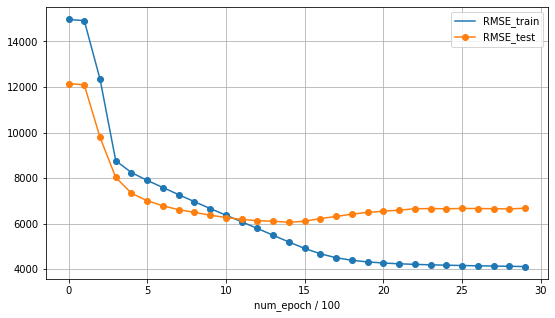

В результате:
RMSE на трейне: tensor(4102.7568, grad_fn=<SqrtBackward0>)
RMSE на тесте: tensor(6656.5630, grad_fn=<SqrtBackward0>)


<Figure size 432x288 with 0 Axes>

[CV 2/3] END module__n_hidden_neurons_1=40, module__n_hidden_neurons_2=37, module__n_hidden_neurons_3=11, module__n_hidden_neurons_4=2;, score=-13640.987 total time=   0.8s
[CV 2/3] END module__n_hidden_neurons_1=68, module__n_hidden_neurons_2=15, module__n_hidden_neurons_3=11, module__n_hidden_neurons_4=4;, score=-5779.392 total time=  12.5s
[CV 3/3] END module__n_hidden_neurons_1=68, module__n_hidden_neurons_2=15, module__n_hidden_neurons_3=11, module__n_hidden_neurons_4=4;, score=-4215.958 total time=  10.3s
[CV 1/3] END module__n_hidden_neurons_1=68, module__n_hidden_neurons_2=15, module__n_hidden_neurons_3=11, module__n_hidden_neurons_4=4;, score=-7733.739 total time=  13.0s
[CV 2/3] END module__n_hidden_neurons_1=40, module__n_hidden_neurons_2=33, module__n_hidden_neurons_3=5, module__n_hidden_neurons_4=2;, score=-5785.724 total time=  10.1s
[CV 3/3] END module__n_hidden_neurons_1=40, module__n_hidden_neurons_2=33, module__n_hidden_neurons_3=5, module__n_hidden_neurons_4=2;, scor

In [247]:
# best_neurons = [13, 52, 34, 24, 8, 3, 1]
best_neurons = [13, 46, 39, 5, 4, 1]
super_net, super_preds_train, super_preds_test = proceed_and_get_metrics(n_neurons=best_neurons)

Для дальнейших экспериментов выбрали модель с `n_neurons = [13, 46, 39, 5, 4, 1]`, найденную RandomizedSearchCV. Ее метрики при обучении на 3_000 эпох:
* RMSE на трейне: tensor(4102.7568, grad_fn=<SqrtBackward0>)
* RMSE на тесте: tensor(6656.5630, grad_fn=<SqrtBackward0>)

### Выбор базовой модели

In [250]:
best_neurons = [13, 46, 39, 5, 4, 1] #[13, 52, 34, 24, 8, 3, 1]
baseline = make_net(n_neurons=best_neurons)

Sequential(
  (0): Linear(in_features=13, out_features=46, bias=True)
  (1): ReLU()
  (2): Linear(in_features=46, out_features=39, bias=True)
  (3): ReLU()
  (4): Linear(in_features=39, out_features=5, bias=True)
  (5): ReLU()
  (6): Linear(in_features=5, out_features=4, bias=True)
  (7): ReLU()
  (8): Linear(in_features=4, out_features=1, bias=True)
  (9): ReLU()
)


Выведем описание целевого признака. Стандартное отклонение для тренировочного датасета - 9_910 K. Для тестового - 8_471 K. RMSE значительно ниже стандартного отколения, но все еще высокий.

In [251]:
print(pd.DataFrame(data=y_train.detach().numpy()).describe())
print(pd.DataFrame(data=y_test.detach().numpy()).describe())

              0
count    168.00
mean  11,241.21
std    9,910.76
min    1,939.00
25%    3,430.50
50%    7,465.00
75%   17,125.00
max   40,000.00
              0
count     72.00
mean   8,762.04
std    8,471.51
min    2,600.00
25%    3,316.75
50%    3,676.00
75%   11,062.50
max   34,190.00


### Визуализация предсказаний
Выведем результаты предсказаний выбранной базовой модели и соответствующие им значения целевого признака на один график. Все предсказания на график влезают плохо, график становится нечитаемый. Поэтому выводим часть.

In [252]:
def graph_for_fact_and_preds(preds, target, title='Target and predictions'):
    preds = list(np.array(preds.tolist()).flat)
    target = list(np.array(target.tolist()).flat)

    n = len(preds)
    r = np.arange(n)
    width = 0.4

    plt.figure(figsize=(30,20)) 
    
    plt.bar(r, preds, color = 'b',
            width = width, edgecolor = 'black',
            label='preds')
    plt.bar(r + width, target, color = 'g',
            width = width, edgecolor = 'black',
            label='target')

    plt.xlabel("Number")
    plt.ylabel("Temperature (K)")
    plt.title(title)

    plt.xticks(r + width/2, np.arange(n))
    plt.legend()

    plt.show()

MyNet2(
  (net): Sequential(
    (0): Linear(in_features=13, out_features=46, bias=True)
    (1): ReLU()
    (2): Linear(in_features=46, out_features=39, bias=True)
    (3): ReLU()
    (4): Linear(in_features=39, out_features=5, bias=True)
    (5): ReLU()
    (6): Linear(in_features=5, out_features=4, bias=True)
    (7): ReLU()
    (8): Linear(in_features=4, out_features=1, bias=True)
  )
)


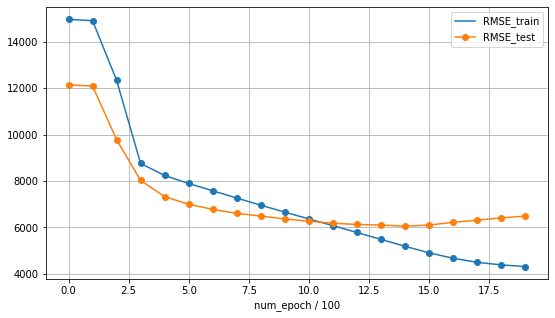

В результате:
RMSE на трейне: tensor(4267.5410, grad_fn=<SqrtBackward0>)
RMSE на тесте: tensor(6547.3853, grad_fn=<SqrtBackward0>)


<Figure size 432x288 with 0 Axes>

In [253]:
baseline, base_preds_train, base_preds_test = proceed_and_get_metrics(n_neurons=best_neurons, num_epochs=2_000, print_metrics_progress=False)

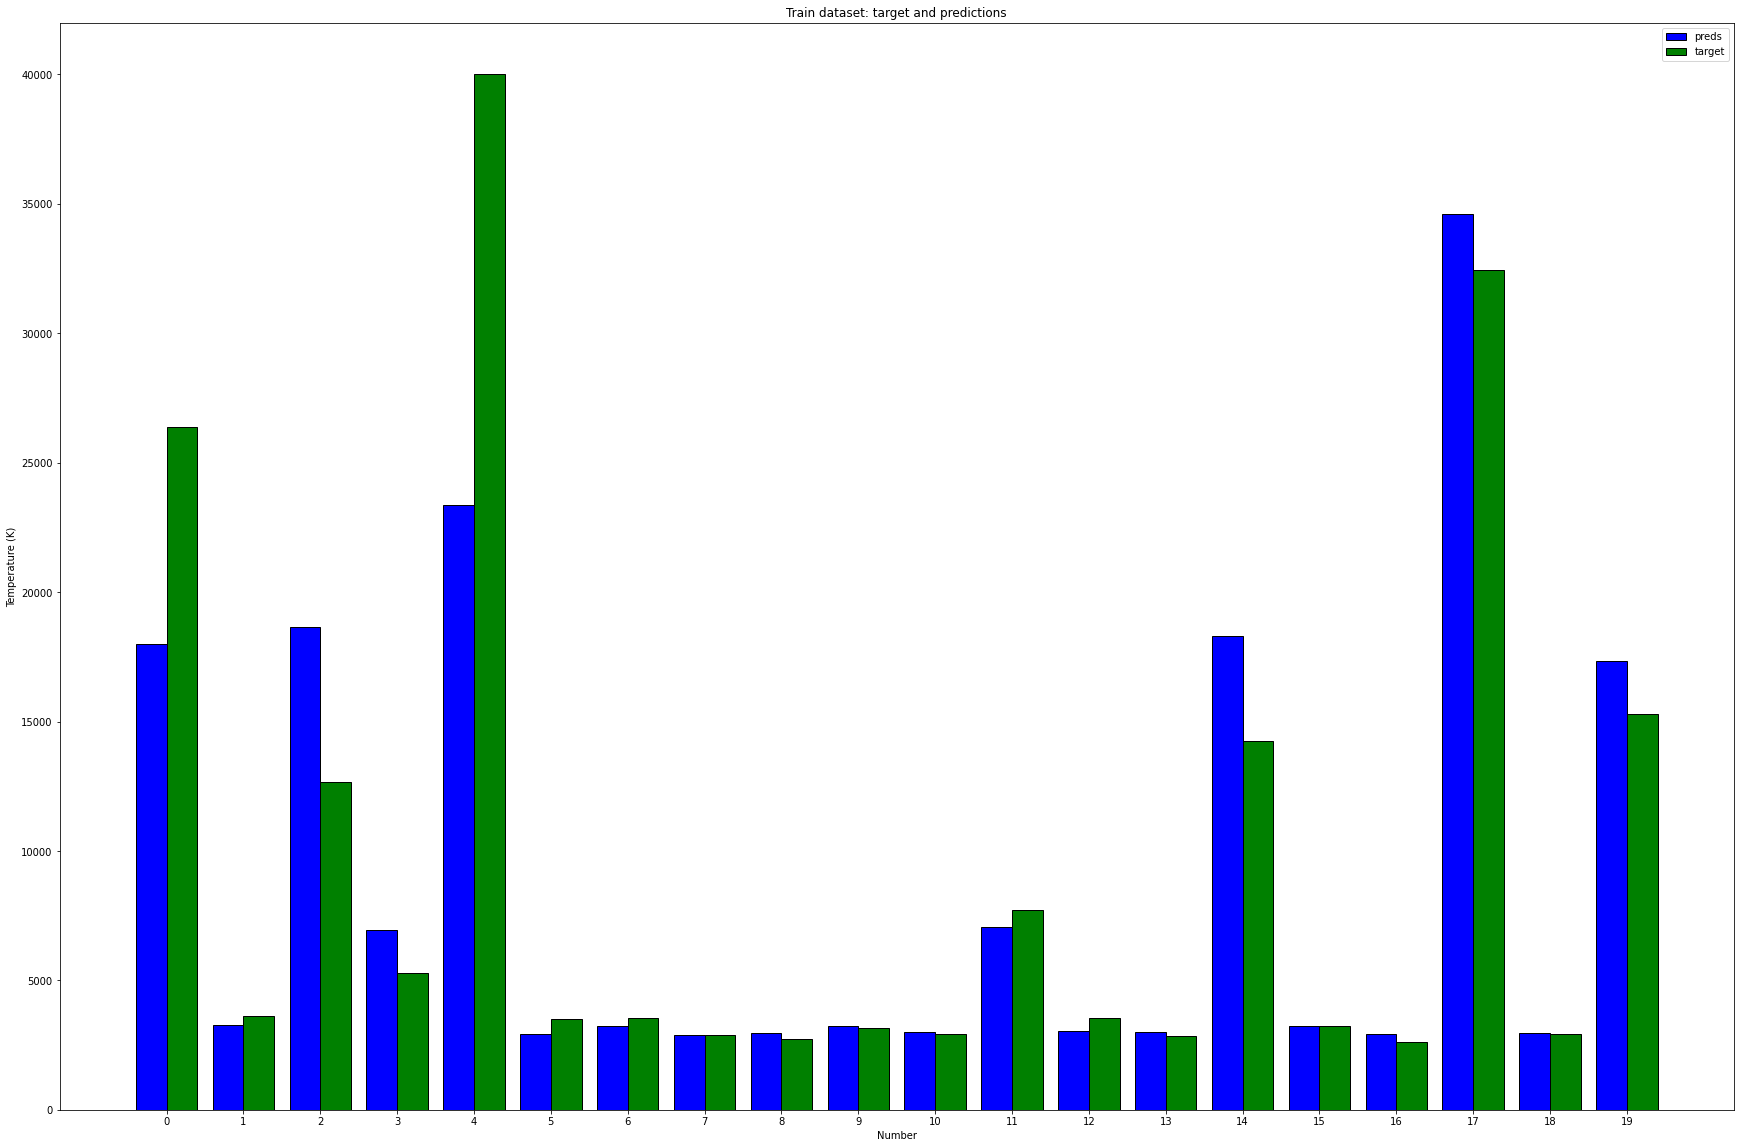

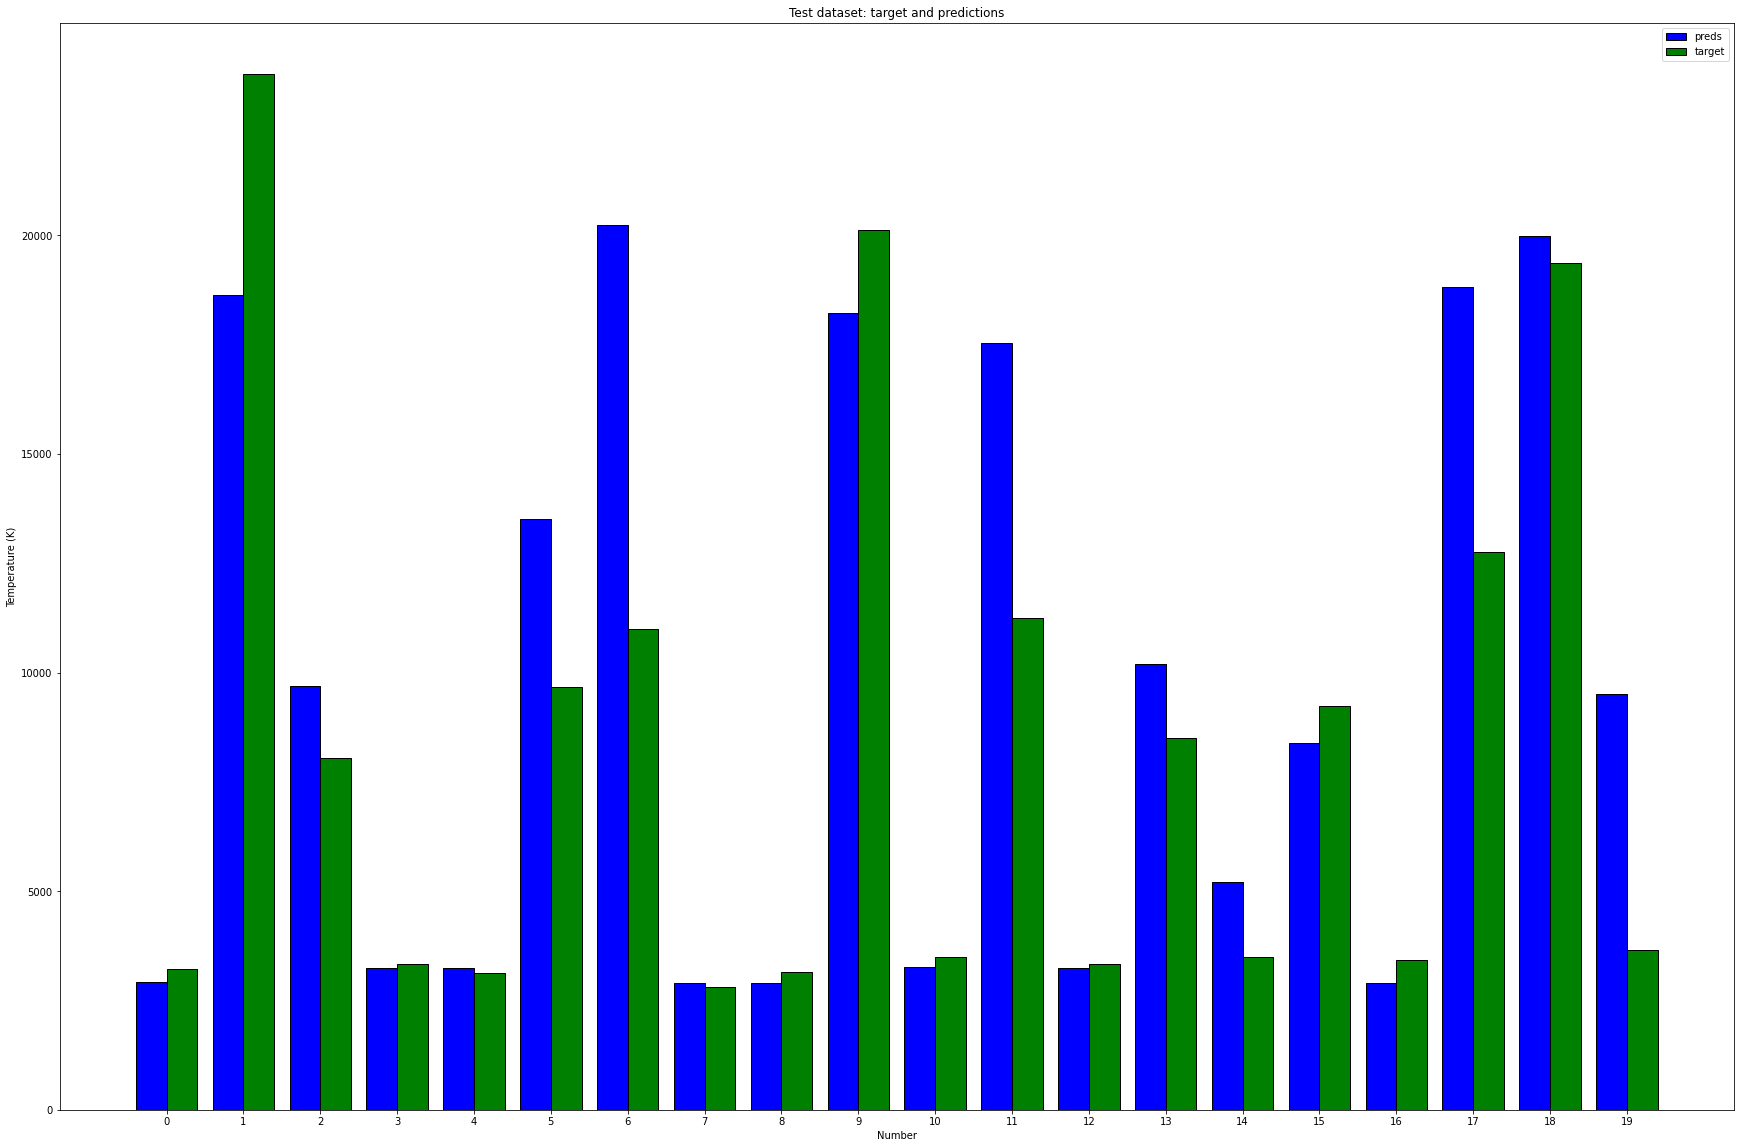

In [254]:
start, end = 20, 40
graph_for_fact_and_preds(base_preds_train[start:end], y_train[start:end], 'Train dataset: target and predictions')
graph_for_fact_and_preds(base_preds_test[start:end], y_test[start:end], 'Test dataset: target and predictions')

## Улучшение базовой модели
Попробуем улучшить базовую модель, подобрав количество эпох, размер батча, батч норм и дропаут. 

### Подбор через GridSearchCV и RandomizedSearchCV
Подберем лучшие параметры через RandomizedSearchCV. Отталкиваться будем от базовой модели.

In [255]:
# базовая модель
baseline

MyNet2(
  (net): Sequential(
    (0): Linear(in_features=13, out_features=46, bias=True)
    (1): ReLU()
    (2): Linear(in_features=46, out_features=39, bias=True)
    (3): ReLU()
    (4): Linear(in_features=39, out_features=5, bias=True)
    (5): ReLU()
    (6): Linear(in_features=5, out_features=4, bias=True)
    (7): ReLU()
    (8): Linear(in_features=4, out_features=1, bias=True)
  )
)

Попробуем подобрать параметры с помощью RandomizedSearchCV:

In [258]:
skorch_regressor = NeuralNetRegressor(module=MyNet,
                                      module__n_hidden_neurons_1=best_neurons[1],
                                      module__n_hidden_neurons_2=best_neurons[2],
                                      module__n_hidden_neurons_3=best_neurons[3],
                                      module__n_hidden_neurons_4=best_neurons[4],
                                      #module__n_hidden_neurons_5=best_neurons[5],
                                      device='cpu',  
                                      verbose=0,
                                      optimizer=torch.optim.Adam, 
                                      max_epochs=5000, 
                                      lr=5e-2,
                                      train_split=ValidSplit(cv=3),
                                      criterion=nn.MSELoss,
                                      callbacks=[
                ('val_rmse', EpochScoring(scoring=rmse_scorer, lower_is_better=True, name='RMSE')),
                ('estoper', EarlyStopping( lower_is_better=True, monitor='RMSE', patience=40)),
                ],
                                     )

skorch_regressor.fit(X_train, y_train.reshape(-1,1))

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=MyNet(
    (fc1): Linear(in_features=13, out_features=46, bias=True)
    (act1): ReLU()
    (dp1): Dropout(p=0, inplace=False)
    (fc2): Linear(in_features=46, out_features=39, bias=True)
    (act2): ReLU()
    (dp2): Dropout(p=0, inplace=False)
    (fc3): Linear(in_features=39, out_features=5, bias=True)
    (act3): ReLU()
    (dp3): Dropout(p=0, inplace=False)
    (fc4): Linear(in_features=5, out_features=4, bias=True)
    (act4): ReLU()
    (dp4): Dropout(p=0, inplace=False)
    (fc6): Linear(in_features=4, out_features=1, bias=True)
  ),
)

In [259]:
params = {  'batch_size': range(4, 100, 5),
            'module__dropout': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
         }

grid = RandomizedSearchCV(skorch_regressor, 
                          params,
                          n_iter=500,
                          cv=3, 
                          scoring='neg_root_mean_squared_error',
                          verbose=3, 
                          n_jobs=12) 

grid.fit(X_train, y_train.reshape(-1,1)) 

Fitting 3 folds for each of 180 candidates, totalling 540 fits
[CV 3/3] END batch_size=4, module__dropout=0.0;, score=-4708.936 total time=   9.8s
[CV 2/3] END batch_size=4, module__dropout=0.2;, score=-6396.806 total time=  11.6s
[CV 2/3] END batch_size=4, module__dropout=0.0;, score=-6449.417 total time=  11.8s
[CV 3/3] END batch_size=4, module__dropout=0.2;, score=-7022.254 total time=  14.0s
[CV 2/3] END batch_size=4, module__dropout=0.1;, score=-5070.160 total time=  18.2s
[CV 1/3] END batch_size=4, module__dropout=0.2;, score=-9297.015 total time=  19.9s
[CV 2/3] END batch_size=4, module__dropout=0.4;, score=-13612.963 total time=   8.3s
[CV 1/3] END batch_size=4, module__dropout=0.5;, score=-13237.789 total time=   8.0s
[CV 2/3] END batch_size=4, module__dropout=0.3;, score=-9077.345 total time=   9.4s
[CV 1/3] END batch_size=4, module__dropout=0.4;, score=-11658.570 total time=  16.9s
[CV 3/3] END batch_size=4, module__dropout=0.6;, score=-10604.102 total time=   9.0s
[CV 2/3] 

RandomizedSearchCV(cv=3,
                   estimator=<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=MyNet(
    (fc1): Linear(in_features=13, out_features=46, bias=True)
    (act1): ReLU()
    (dp1): Dropout(p=0, inplace=False)
    (fc2): Linear(in_features=46, out_features=39, bias=True)
    (act2): ReLU()
    (dp2): Dropout(p=0, inplace=False)
    (fc3): Linear(in_features=39, out_features=5, bia...
    (dp3): Dropout(p=0, inplace=False)
    (fc4): Linear(in_features=5, out_features=4, bias=True)
    (act4): ReLU()
    (dp4): Dropout(p=0, inplace=False)
    (fc6): Linear(in_features=4, out_features=1, bias=True)
  ),
),
                   n_iter=500, n_jobs=12,
                   param_distributions={'batch_size': range(4, 100, 5),
                                        'module__dropout': [0.0, 0.1, 0.2, 0.3,
                                                            0.4, 0.5, 0.6, 0.7,
                                                            0.8]},
      

[CV 1/3] END batch_size=99, module__dropout=0.6;, score=-11781.695 total time=   3.2s
[CV 3/3] END batch_size=99, module__dropout=0.7;, score=-12987.236 total time=   1.1s
[CV 3/3] END batch_size=99, module__dropout=0.6;, score=-10997.075 total time=   3.0s
[CV 2/3] END batch_size=99, module__dropout=0.8;, score=-12093.231 total time=   1.2s
[CV 2/3] END batch_size=99, module__dropout=0.7;, score=-10059.606 total time=   3.0s
[CV 1/3] END batch_size=99, module__dropout=0.8;, score=-15135.595 total time=   2.2s
[CV 3/3] END batch_size=99, module__dropout=0.8;, score=-14073.870 total time=   1.9s
[CV 1/3] END batch_size=84, module__dropout=0.1;, score=-16295.615 total time= 2.6min


In [260]:
print(grid.best_params_)
print(grid.best_score_)

{'module__dropout': 0.1, 'batch_size': 99}
-5891.850911458333
[CV 1/3] END batch_size=94, module__dropout=0.0;, score=-16295.531 total time= 2.0min


Сузим круг поиска и воспользуемся GridSearchCV.

In [261]:
params = {  'batch_size': range(90, 101, 5),
            'module__dropout': [0.0, 0.05, 0.1, 0.15],
         }

grid2 = GridSearchCV(skorch_regressor, 
                    params, 
                    cv=3, 
                    scoring='neg_root_mean_squared_error', 
                    verbose=3, 
                    n_jobs=12) 

grid2.fit(X_train, y_train.reshape(-1,1)) 

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END batch_size=4, module__dropout=0.0;, score=-13765.253 total time=19.0min
[CV 3/3] END batch_size=4, module__dropout=0.1;, score=-11738.198 total time=19.0min
[CV 1/3] END batch_size=4, module__dropout=0.1;, score=-13765.009 total time=19.1min
[CV 2/3] END batch_size=90, module__dropout=0.0;, score=-13639.781 total time=   0.8s
[CV 2/3] END batch_size=90, module__dropout=0.1;, score=-13640.135 total time=   0.8s
[CV 3/3] END batch_size=90, module__dropout=0.0;, score=-4553.583 total time=   6.0s
[CV 1/3] END batch_size=90, module__dropout=0.0;, score=-7804.682 total time=   6.7s
[CV 3/3] END batch_size=90, module__dropout=0.05;, score=-8613.902 total time=   1.7s
[CV 1/3] END batch_size=95, module__dropout=0.0;, score=-7752.922 total time=   6.1s
[CV 2/3] END batch_size=90, module__dropout=0.05;, score=-5587.491 total time=   5.8s
[CV 3/3] END batch_size=95, module__dropout=0.0;, score=-4391.772 total time=   3.9s


GridSearchCV(cv=3,
             estimator=<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=MyNet(
    (fc1): Linear(in_features=13, out_features=46, bias=True)
    (act1): ReLU()
    (dp1): Dropout(p=0, inplace=False)
    (fc2): Linear(in_features=46, out_features=39, bias=True)
    (act2): ReLU()
    (dp2): Dropout(p=0, inplace=False)
    (fc3): Linear(in_features=39, out_features=5, bias=True)
    (act3): ReLU()
    (dp3): Dropout(p=0, inplace=False)
    (fc4): Linear(in_features=5, out_features=4, bias=True)
    (act4): ReLU()
    (dp4): Dropout(p=0, inplace=False)
    (fc6): Linear(in_features=4, out_features=1, bias=True)
  ),
),
             n_jobs=12,
             param_grid={'batch_size': range(90, 101, 5),
                         'module__dropout': [0.0, 0.05, 0.1, 0.15]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [262]:
print(grid2.best_params_)
print(grid2.best_score_)

{'batch_size': 95, 'module__dropout': 0.05}
-6039.373046875


Попробуем запустить сеть с этими параметрами {'batch_size': 95, 'module__dropout': 0.05} через skorch_regressor. Метрика RMSE на тесте получилась значительно выше (6571), чем средняя при запуске через GridSearchCV, модель перестала обучаться через 238 эпох. :(

In [263]:
skorch_regressor = NeuralNetRegressor(module=MyNet,
                                      module__n_hidden_neurons_1=best_neurons[1],
                                      module__n_hidden_neurons_2=best_neurons[2],
                                      module__n_hidden_neurons_3=best_neurons[3],
                                      module__n_hidden_neurons_4=best_neurons[4],
                                      #module__n_hidden_neurons_5=best_neurons[5],
                                      module__dropout=0.1,
                                      device='cpu',  
                                      verbose=1,
                                      batch_size=75,
                                      optimizer=torch.optim.Adam, 
                                      max_epochs=6000, 
                                      lr=5e-2,
                                      train_split=ValidSplit(cv=3),
                                      criterion=nn.MSELoss,
                                      callbacks=[
                ('val_rmse', EpochScoring(scoring=rmse_scorer, lower_is_better=True, name='RMSE')),
                ('estoper', EarlyStopping( lower_is_better=True, monitor='RMSE', patience=50)),
                ],
                                     )


skorch_regressor.fit(X_train, y_train.reshape(-1,1)) 

  epoch        RMSE      train_loss      valid_loss     dur
-------  ----------  --------------  --------------  ------
      1  16471.6328  200306118.5714  271314720.0000  0.0085
      2  16460.4414  200218720.2857  270946144.0000  0.0093
      3  16424.1250  199808818.7143  269751904.0000  0.0090
      4  16329.6016  198505239.0000  266655872.0000  0.0097
      5  16119.4443  195615928.2857  259836512.0000  0.0150
      6  15704.7764  188709234.7143  246640016.0000  0.0249
      7  14950.1494  176169612.5714  223506992.0000  0.0067
      8  13697.4453  155955144.1429  187620016.0000  0.0092
      9  11933.2051  127107376.0714  142401376.0000  0.0083
     10  10474.0010  106783927.7143  109704720.0000  0.0087
     11  10342.2822  105710549.8571  106962808.0000  0.0102
     12  9998.2441  116422057.2143  99964880.0000  0.0092
     13  10194.3252  108043932.5000  103924264.0000  0.0096
     14  10634.2959  80561276.5714  113088256.0000  0.0084
     15  10753.1514  87192622.7857  1156302

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=MyNet(
    (fc1): Linear(in_features=13, out_features=46, bias=True)
    (act1): ReLU()
    (dp1): Dropout(p=0.1, inplace=False)
    (fc2): Linear(in_features=46, out_features=39, bias=True)
    (act2): ReLU()
    (dp2): Dropout(p=0.1, inplace=False)
    (fc3): Linear(in_features=39, out_features=5, bias=True)
    (act3): ReLU()
    (dp3): Dropout(p=0.1, inplace=False)
    (fc4): Linear(in_features=5, out_features=4, bias=True)
    (act4): ReLU()
    (dp4): Dropout(p=0.1, inplace=False)
    (fc6): Linear(in_features=4, out_features=1, bias=True)
  ),
)

Создадим и обучим модель, которая выбрана GridSearchCV в качестве оптимальной. Обучим ее в течение 1_500 эпох. 

MyNet2(
  (net): Sequential(
    (0): Linear(in_features=13, out_features=46, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.05, inplace=False)
    (3): Linear(in_features=46, out_features=39, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.05, inplace=False)
    (6): Linear(in_features=39, out_features=5, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.05, inplace=False)
    (9): Linear(in_features=5, out_features=4, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.05, inplace=False)
    (12): Linear(in_features=4, out_features=1, bias=True)
  )
)


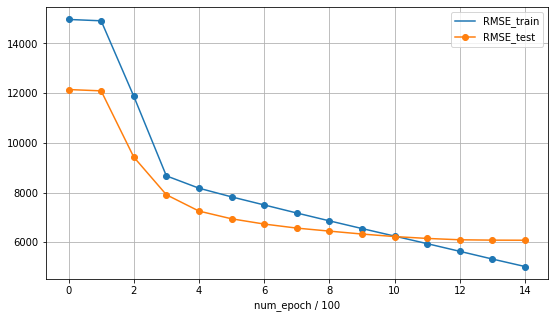

В результате:
RMSE на трейне: tensor(4758.6929, grad_fn=<SqrtBackward0>)
RMSE на тесте: tensor(6162.4634, grad_fn=<SqrtBackward0>)


<Figure size 432x288 with 0 Axes>

In [275]:
net_v3, net_v3_preds_train, net_v3_preds_test = proceed_and_get_metrics(
                                                    n_neurons=best_neurons,
                                                    num_epochs=1_500,
                                                    dropout=True,
                                                    #dropout_shares=[grid2.best_params_['module__dropout']]*5,
                                                    dropout_shares=[0.05]*5,
                                                    batch_size=grid2.best_params_['batch_size'])

#### Получившиеся модели
В итоге имеем две модели: базовую и модель, подобранную гридсерчем на основе базовой.

In [268]:
models_info = [['Baseline', baseline, base_preds_train, base_preds_test],
               #['NetThin', net_thin, net_thin_preds_train, net_thin_preds_test],
               ['NetV3 (GridSearchCV)', net_v3, net_v3_preds_train, net_v3_preds_test]]

for model_info in models_info:
    name = model_info[0]
    model = model_info[1]
    preds_train = model_info[2]
    preds_test = model_info[3]
    train_rmse = rmse(preds_train.detach().numpy(), y_train.detach().numpy())
    test_rmse = rmse(preds_test.detach().numpy(), y_test.detach().numpy())
    print(name)
    print(model)
    print('RMSE on train:', train_rmse)
    print('RMSE on test:', test_rmse)
    print(); print()
    
    

Baseline
MyNet2(
  (net): Sequential(
    (0): Linear(in_features=13, out_features=46, bias=True)
    (1): ReLU()
    (2): Linear(in_features=46, out_features=39, bias=True)
    (3): ReLU()
    (4): Linear(in_features=39, out_features=5, bias=True)
    (5): ReLU()
    (6): Linear(in_features=5, out_features=4, bias=True)
    (7): ReLU()
    (8): Linear(in_features=4, out_features=1, bias=True)
  )
)
RMSE on train: 4267.541
RMSE on test: 6547.3857


NetV3 (GridSearchCV)
MyNet2(
  (net): Sequential(
    (0): Linear(in_features=13, out_features=46, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.05, inplace=False)
    (3): Linear(in_features=46, out_features=39, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.05, inplace=False)
    (6): Linear(in_features=39, out_features=5, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.05, inplace=False)
    (9): Linear(in_features=5, out_features=4, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.05, inplace=False)
    (12): Linear(in_features=4, ou

## Вывод по работе
### Постановка задачи
Задача данного исследования - разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды. Заказчик исследования - лаборатория "Небо на ладони".

### Исходные данные
Исходные данные представляют собой датасет, в котором содержится информация о 240 уже изученных звездах, количество колонок - 7. Пустых значений, выбросов, дубликатов нет. Есть один неинформативный признак - id звезды.

Есть выраженные корреляции целевого признака с обучающими:
* средней силы положительная корреляция с относительной светимостью (Luminosity) - К = 0.39;
* средней силы отрицательная корреляция с абсолютной звездной величиной (Absolute magnitude) - К = -0.41

### Предобработка данных
В ходе предобработки были переименованы колонки, изменен тип данных в колонке 'Star type' на object, что соответствует природе данных. Удален неинформативный столбец 'Unnamed' c id звезды. Удалены скрытые дубликаты в колонке 'Star color'.

Структура получившегося датасета:
* целевой признак - 'temperature' - температура на поверхности звезды в градусах Kельвина. 
* пять обучающих признаков: три численные ('luminosity', 'radius', 'absolute_magnitude') и два категориальные ('star_type', 'star_color').

### Подготовка датасетов для обучения моделей
В ходе предобработки было произведено кодирования категориальных признаков методом OHE, масштабирование численных признаков с использованием StandardScaler(). В получившемся датасете 240 строк и 13 колонок. 

Датасет разделен на тренировочный и тестовый, получившиеся датасеты конвертированы в тензоры.


### Выбор базовой конфигурации модели
Исходя из получившегося датасета и задачи исследования, в качестве отправной точки была выбрана конфигурация модели нейронной сети - прямая полносвязная сеть с 13 входными нейронами, одним скрытым слоем из четырех нейронов, и выходным слоем, в котором один нейрон.

В ходе экспериментов были испробованы различные комбинации нейронов в слоях, функции активации скрытых слоев, функция активации выходного слоя.

Лучше всего показала себя модель с пятью скрытыми слоями. Ее конфигурация:


In [504]:
net_thin

Sequential(
  (0): Linear(in_features=13, out_features=11, bias=True)
  (1): ReLU()
  (2): Linear(in_features=11, out_features=9, bias=True)
  (3): ReLU()
  (4): Linear(in_features=9, out_features=7, bias=True)
  (5): ReLU()
  (6): Linear(in_features=7, out_features=5, bias=True)
  (7): ReLU()
  (8): Linear(in_features=5, out_features=3, bias=True)
  (9): ReLU()
  (10): Linear(in_features=3, out_features=1, bias=True)
  (11): ReLU()
)

RMSE ниже стандартного отклонения целевого признака:
* RMSE on train: 3355.4382
* RMSE on test: 5890.4087
    

### Окончательный выбор базовой модели
Для развития выбрана модель с большим количеством нейронов в слоях:
* n_neurons = [13, 32, 16, 15, 4, 2, 1]
* batch_size = 10
* dropout = 0.1

Ее метрики: 
* RMSE на трейне: tensor(3265.3425, grad_fn=<SqrtBackward0>)
* RMSE на тесте: tensor(6301.6914, grad_fn=<SqrtBackward0>)

Sequential(
  (0): Linear(in_features=13, out_features=32, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=32, out_features=16, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=16, out_features=15, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=15, out_features=4, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.1, inplace=False)
  (12): Linear(in_features=4, out_features=2, bias=True)
  (13): ReLU()
  (14): Dropout(p=0.1, inplace=False)
  (15): Linear(in_features=2, out_features=1, bias=True)
  (16): ReLU()
)


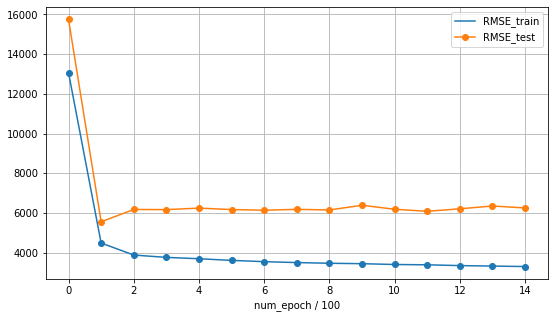

В результате:
RMSE на трейне: tensor(3265.3425, grad_fn=<SqrtBackward0>)
RMSE на тесте: tensor(6301.6914, grad_fn=<SqrtBackward0>)


(Sequential(
   (0): Linear(in_features=13, out_features=32, bias=True)
   (1): ReLU()
   (2): Dropout(p=0.1, inplace=False)
   (3): Linear(in_features=32, out_features=16, bias=True)
   (4): ReLU()
   (5): Dropout(p=0.1, inplace=False)
   (6): Linear(in_features=16, out_features=15, bias=True)
   (7): ReLU()
   (8): Dropout(p=0.1, inplace=False)
   (9): Linear(in_features=15, out_features=4, bias=True)
   (10): ReLU()
   (11): Dropout(p=0.1, inplace=False)
   (12): Linear(in_features=4, out_features=2, bias=True)
   (13): ReLU()
   (14): Dropout(p=0.1, inplace=False)
   (15): Linear(in_features=2, out_features=1, bias=True)
   (16): ReLU()
 ),
 tensor([32172.0859,  3314.2561,  9120.0674, 20768.6699, 27664.0000, 16617.5273,
          4093.7095,  3913.6177, 37609.6055, 12179.3281,  3281.5703, 21041.9883,
          4052.8325,  2901.6265, 19817.6777,  3219.5212,  7323.4775, 19817.5645,
         37297.7070, 18476.4668, 19447.9473,  3597.5107, 18067.2188,  5606.0781,
         28402.7949,  3

<Figure size 432x288 with 0 Axes>

In [606]:
proceed_and_get_metrics(n_neurons=best_neurons,
                        batch_size=10,
                        num_epochs=1_500,
                        dropout=True,
                        dropout_shares=[0.1]*5,
                        print_net=True,
                        print_metrics_progress=False
                        )

### Визуализация результатов
Чтоб продемонстрировать результат, выведем фрагмент предсказаний выбранной модели и соответствующие им значения целевого признака на один график.

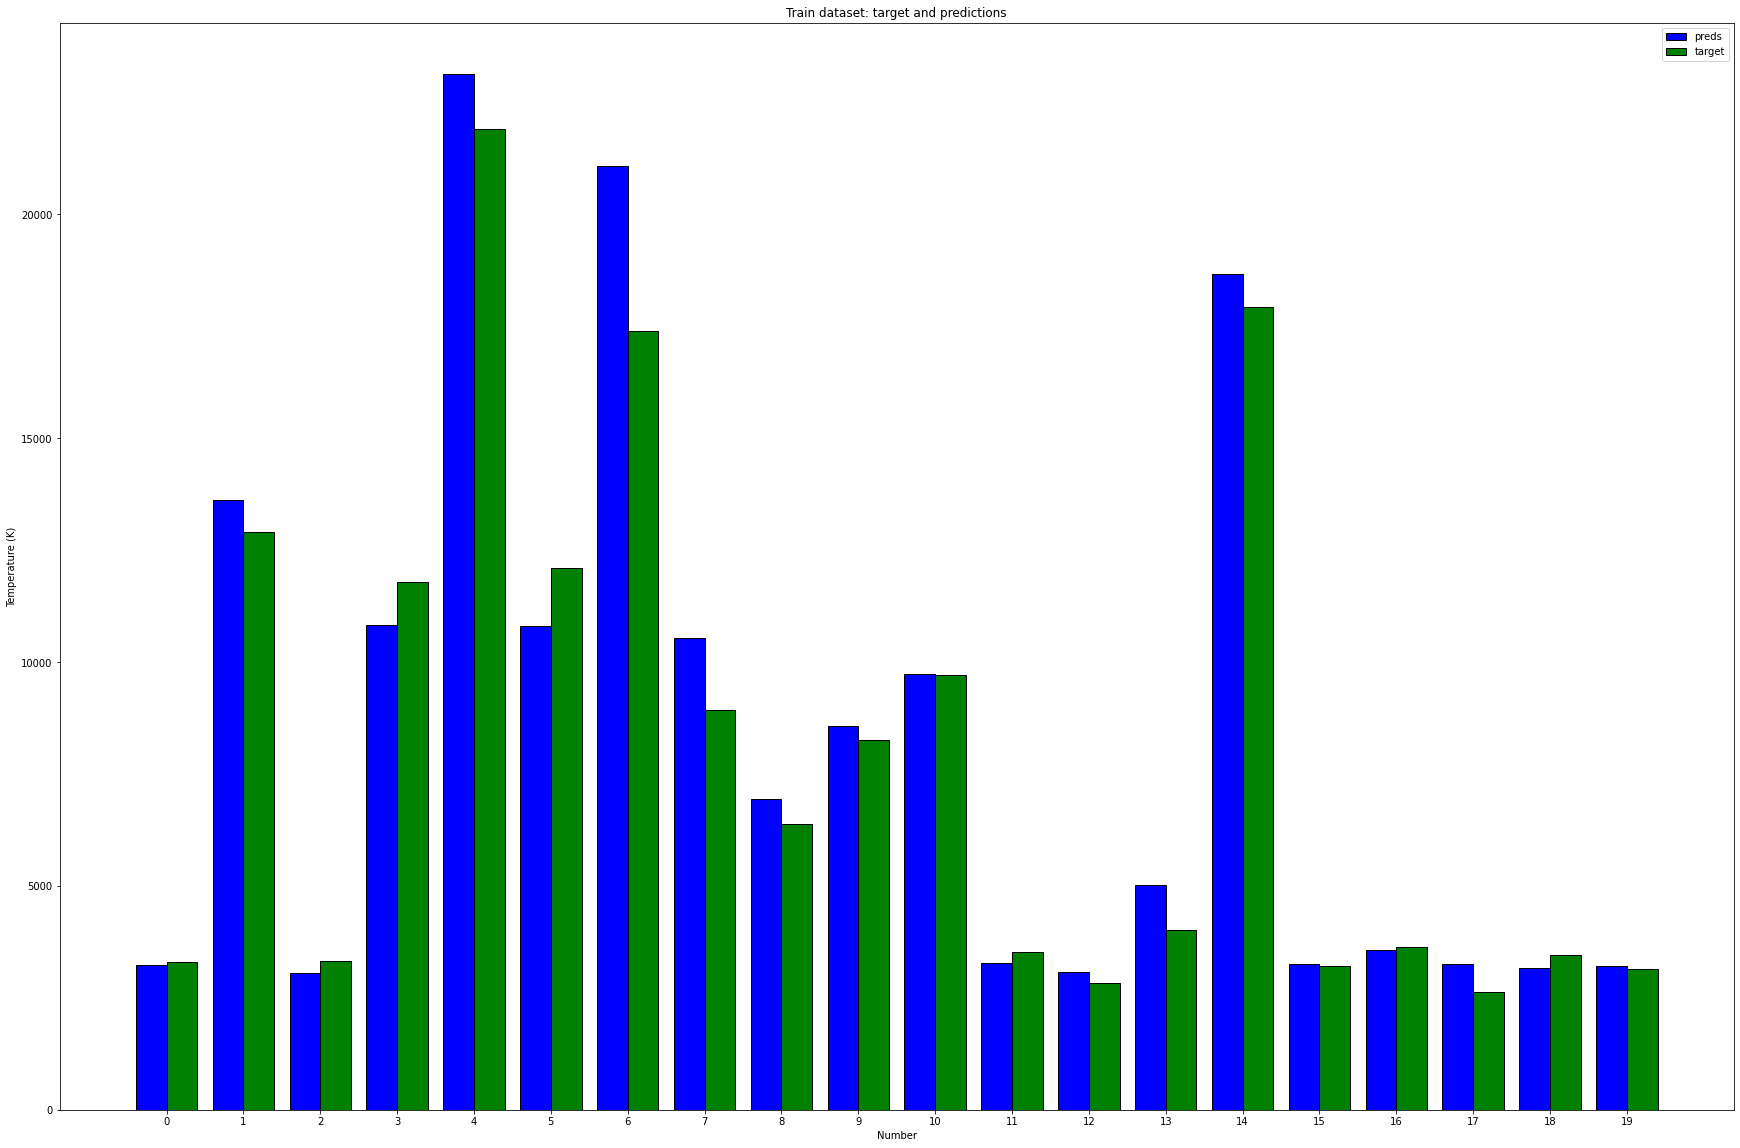

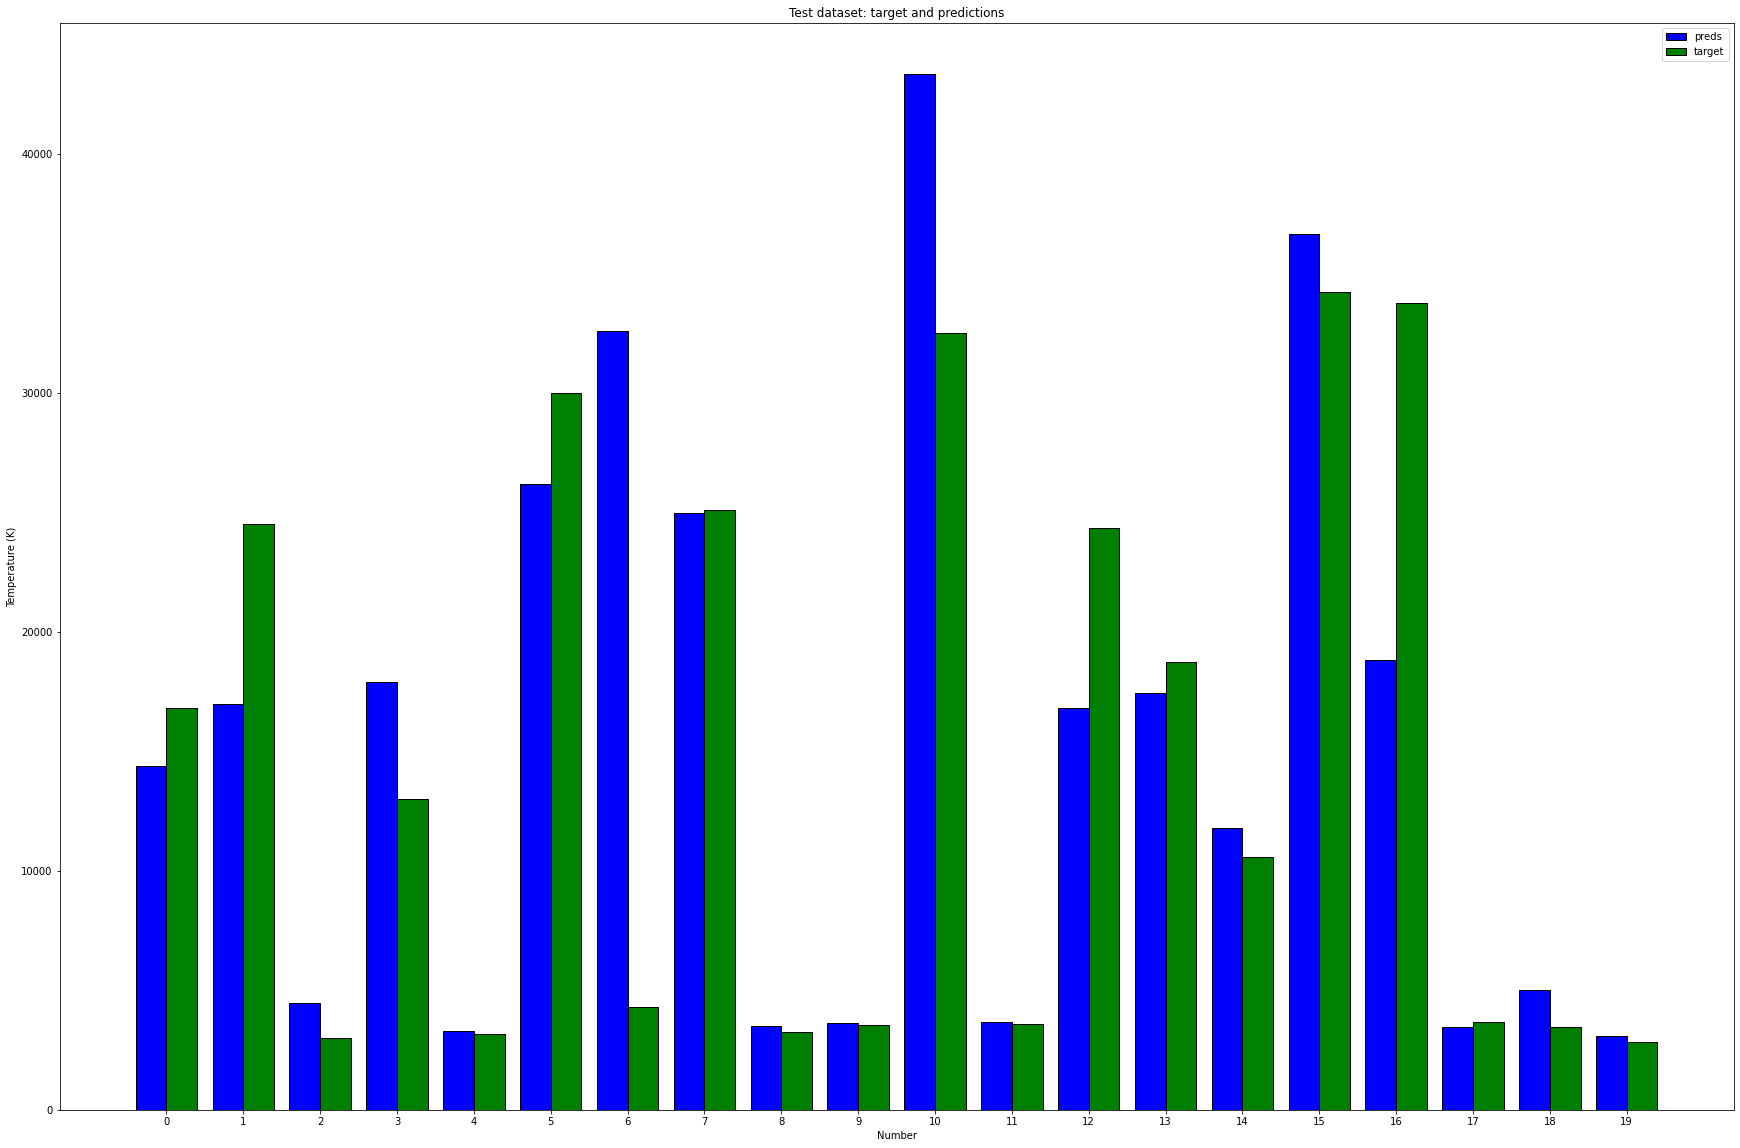

In [515]:
start, end = 50, 70

graph_for_fact_and_preds(net_v3_preds_train[start:end], y_train[start:end], 'Train dataset: target and predictions')
graph_for_fact_and_preds(net_v3_preds_test[start:end], y_test[start:end], 'Test dataset: target and predictions')